In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
basics = pd.read_csv("title.basics.tsv.gz", sep="\t", na_values="\\N", low_memory=False)
ratings = pd.read_csv("title.ratings.tsv.gz", sep="\t", na_values="\\N")

df = pd.merge(basics, ratings, on="tconst", how="inner")

df = df[["tconst", "primaryTitle", "startYear", "runtimeMinutes",
         "averageRating", "numVotes"]]

# Convert numeric columns
df["runtimeMinutes"] = pd.to_numeric(df["runtimeMinutes"], errors="coerce")
df["startYear"] = pd.to_numeric(df["startYear"], errors="coerce")

# Apply filters
df = df.dropna(subset=["averageRating", "numVotes", "runtimeMinutes", "startYear"])
df = df[df["runtimeMinutes"] > 0]
df = df[df["startYear"] >= 2012]
df = df[df["numVotes"] > 50]

# Sample 2000 rows for modeling
df_sample = df.sample(n=2000, random_state=42)
df_sample.head()

,tconst,primaryTitle,startYear,runtimeMinutes,averageRating,numVotes
1253384,tt37529078,Yabasugi jan yo,2025.0,24.0,8.9,2917
1255324,tt3760348,Nothing But Blue Skies,2014.0,42.0,7.9,1620
926785,tt2120895,I Danmark er jeg født,2013.0,56.0,7.6,520
1390108,tt5670382,A Moving Image,2016.0,74.0,6.0,83
1158467,tt32461003,The Last Supper,2025.0,114.0,5.1,1223


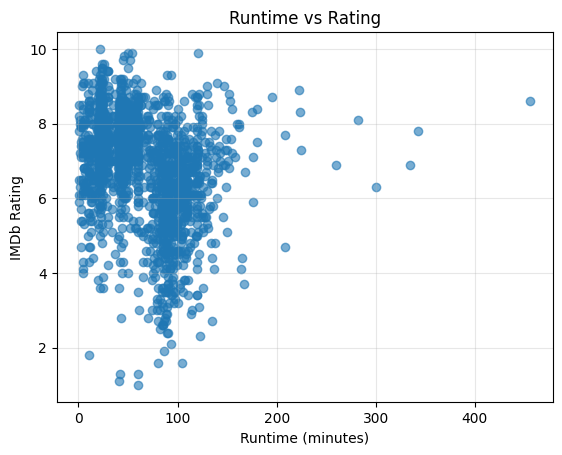

Correlation: -0.3173711353263882


In [3]:
plt.scatter(df_sample["runtimeMinutes"], df_sample["averageRating"], alpha=0.6)
plt.xlabel("Runtime (minutes)")
plt.ylabel("IMDb Rating")
plt.title("Runtime vs Rating")
plt.grid(True, alpha=0.3)
plt.show()

corr = df_sample["runtimeMinutes"].corr(df_sample["averageRating"])
print("Correlation:", corr)

In [4]:
X = df_sample[["runtimeMinutes", "startYear"]].values
y = df_sample["averageRating"].values.reshape(-1, 1)

# Split into train and test sets (80/20)
np.random.seed(42)
indices = np.random.permutation(len(X))

train_size = int(0.8 * len(X))
train_idx = indices[:train_size]
test_idx = indices[train_size:]

X_train = X[train_idx]
y_train = y[train_idx]

X_test = X[test_idx]
y_test = y[test_idx]

# Normalize 
X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)

X_train_norm = (X_train - X_mean) / X_std
X_test_norm = (X_test - X_mean) / X_std

In [5]:
np.random.seed(42)

class MLP:
    def __init__(self, input_size=2, hidden_size=16, output_size=1):
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2 / input_size)
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2 / hidden_size)
        self.b2 = np.zeros((1, output_size))

    def relu(self, z):
        return np.maximum(0, z)

    def relu_deriv(self, z):
        return (z > 0).astype(float)

    def forward(self, X):
        self.z1 = X @ self.W1 + self.b1
        self.a1 = self.relu(self.z1)
        self.z2 = self.a1 @ self.W2 + self.b2
        return self.z2  # linear output

    def backward(self, X, y, y_pred, lr):
        n = len(y)
        dL_dy = (2 / n) * (y_pred - y)

        dL_dW2 = self.a1.T @ dL_dy
        dL_db2 = dL_dy.sum(axis=0, keepdims=True)

        dL_da1 = dL_dy @ self.W2.T
        dL_dz1 = dL_da1 * self.relu_deriv(self.z1)

        dL_dW1 = X.T @ dL_dz1
        dL_db1 = dL_dz1.sum(axis=0, keepdims=True)

        self.W1 -= lr * dL_dW1
        self.b1 -= lr * dL_db1
        self.W2 -= lr * dL_dW2
        self.b2 -= lr * dL_db2

In [6]:
model = MLP(input_size=2, hidden_size=16, output_size=1)
epochs = 600
lr = 0.01
losses = []

for epoch in range(epochs):
    y_pred_train = model.forward(X_train_norm)
    loss = np.mean((y_train - y_pred_train)**2)
    losses.append(loss)

    model.backward(X_train_norm, y_train, y_pred_train, lr)

    if epoch % 50 == 0:
        print(f"Epoch {epoch}, MSE: {loss:.4f}")

Epoch 0, MSE: 60.4420
Epoch 50, MSE: 3.6714
Epoch 100, MSE: 2.5469
Epoch 150, MSE: 1.9903
Epoch 200, MSE: 1.7443
Epoch 250, MSE: 1.6449
Epoch 300, MSE: 1.6029
Epoch 350, MSE: 1.5813
Epoch 400, MSE: 1.5679
Epoch 450, MSE: 1.5572
Epoch 500, MSE: 1.5478
Epoch 550, MSE: 1.5393


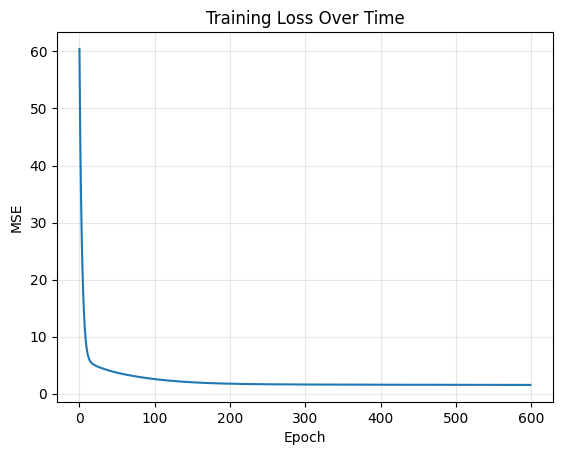

In [7]:
plt.plot(losses)
plt.title("Training Loss Over Time")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.grid(True, alpha=0.3)
plt.show()

In [8]:
y_pred_test = model.forward(X_test_norm)

# Flatten
y_true = y_test.flatten()
y_pred = y_pred_test.flatten()

mse = np.mean((y_true - y_pred)**2)

ss_res = np.sum((y_true - y_pred)**2)
ss_tot = np.sum((y_true - np.mean(y_true))**2)

r2 = 1 - ss_res / ss_tot

In [9]:
# Additional evaluation metrics
test_rmse = np.sqrt(mse)
test_mae = np.mean(np.abs(y_true - y_pred))

# Baseline comparison
baseline_pred = np.full_like(y_true, np.mean(y_train))
baseline_mse = np.mean((y_true - baseline_pred)**2)

# Correlation for comparison
linear_r2 = corr ** 2  # What simple linear would get

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"R-squared: {r2:.4f}")
print(f"\nBaseline MSE: {baseline_mse:.4f} -> Improvement: {((baseline_mse - mse)/baseline_mse*100):.2f}%")
print(f"\nLinear R-squared: {linear_r2:.4f} -> MLP improvement:  {((r2 - linear_r2)/linear_r2*100):.1f}% over linear")
print(f"\nPredicted mean: {y_pred.mean():.4f}, Predicted std: {y_pred.std():.4f}")
print(f"Actual mean: {y_true.mean():.4f}, Actual std: {y_true.std():.4f}")

Test MSE: 1.6999
Test RMSE: 1.3038
Test MAE: 0.9466
R-squared: 0.0919

Baseline MSE: 1.8855 -> Improvement: 9.84%

Linear R-squared: 0.1007 -> MLP improvement:  -8.8% over linear

Predicted mean: 6.9111, Predicted std: 0.6121
Actual mean: 6.7890, Actual std: 1.3682


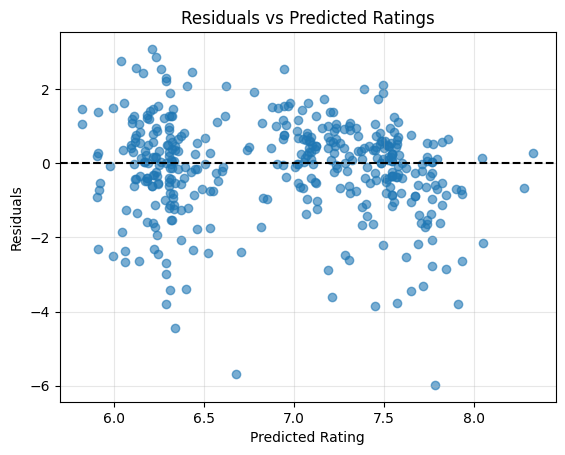

In [10]:
residuals = y_true - y_pred

plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color="black", linestyle="--")
plt.xlabel("Predicted Rating")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Ratings")
plt.grid(True, alpha=0.3)
plt.show()

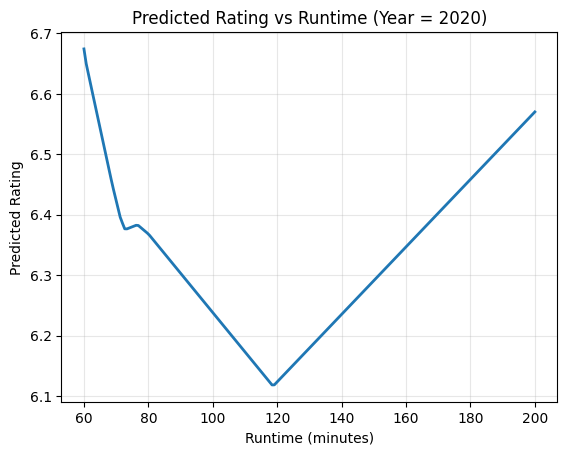

In [11]:
runtime_grid = np.linspace(60, 200, 200)
year_fixed = 2020
X_grid = np.column_stack([runtime_grid, np.full_like(runtime_grid, year_fixed)])
X_grid_norm = (X_grid - X_mean) / X_std

y_grid_pred = model.forward(X_grid_norm).flatten()

plt.plot(runtime_grid, y_grid_pred, linewidth=2)
plt.xlabel("Runtime (minutes)")
plt.ylabel("Predicted Rating")
plt.title("Predicted Rating vs Runtime (Year = 2020)")
plt.grid(True, alpha=0.3)
plt.show()